# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

<div class="span5 alert alert-info">
### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet


#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution
</div>
****

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [3]:
data[['race', 'call']].head()

,race,call
0,w,0.0
1,w,0.0
2,b,0.0
3,b,0.0
4,w,0.0


In [4]:
data.shape

(4870, 65)

In [5]:
data.pivot_table(index='race', columns= 'call', aggfunc='count')['ad']

call,0.0,1.0
race,,
b,2278,157
w,2200,235


### Statistic Test
CTL can be used because $n_1*p_1 > 5$ & $n_1*(1-p_1) > 5$ same for 2nd sample and observations are independent.<br>
Therefore two-proportion $Z$-test is appropriate for this experiment.<br>

In [6]:
callback = data.call
white_callback = callback[data.race=='w']
black_callback = callback[data.race=='b']

In [7]:
# verify conditions of CLT for proportions
assert sum(white_callback) > 5
assert len(white_callback) - sum(white_callback) > 5
assert sum(black_callback) > 5
assert len(black_callback) - sum(black_callback) > 5

### Hypothesis
**Null hypothesis** states that race has no effect in the number of interview callbacks. $ P_b = p_w $<br>
**Alternative hypothesis** is that race has an impact on the number of interview callbacks. $ P_b \neq p_w $

* Two-sample Bootstrapping hypothesis test <br>
Let's derive confidence intervals for each race and see if their respective proportions overlaps.

In [8]:
def draw_bs_proportion(data, size = 1):
    """
    Data: pandas series
    size: number of bootstrap replicates
    Returns a numpy array of proportion for each bootstrap replicate
    """
    bs_data_mean = np.empty(size)
    
    for i in range(size):
        # resample with replacement
        bs_data = data.sample(n = len(data), replace = True)
        # compute proportion
        bs_data_mean[i] = sum(bs_data) / len(bs_data)
    
    return bs_data_mean

In [9]:
# Bootstrapping on each group to determine confidence interval
num_bs = int(1e5)
bs_callback_black = draw_bs_proportion(black_callback, size = num_bs)
bs_callback_white = draw_bs_proportion(white_callback, size = num_bs)

In [10]:
# confidence interval at 1% significance level for black
conf_b = np.percentile(bs_callback_black, [0.5, 99.5])

# confidence interval at 1% significance level for white
conf_w = np.percentile(bs_callback_white, [0.5, 99.5])

# compare confidence intervals
print('Black callback proportion at 99% ' ,conf_b, '\nWhite callback proportion at 99% ', conf_w)

Black callback proportion at 99%  [ 0.05215606  0.07761807] 
White callback proportion at 99%  [ 0.08131417  0.11211499]


**Conclusion :** Confidence interval do not overlap so we can reject the null hypothesis. Callback proportion for white and black people differs. We only proved that callback proportions are different for black and white people. However, there could be other factors such as quality of resume, location and so on. 

* Two-proportion z-test (formula provided in SOLUTION below)

In [11]:
# sample proportion of callbacks for black-sounding names
mean_black = sum(black_callback) / len(black_callback)

# sample proportion of callbacks for white-sounding names
mean_white = sum(white_callback) / len(white_callback)

# sample proportion of callbacks for all
mean_all = sum(callback) / len(callback)

In [12]:
mean_diff_z = mean_white - mean_black
std_error = np.sqrt( mean_all*(1-mean_all) * ((1/len(white_callback))+(1/len(black_callback))) )
z_score = mean_diff_z / std_error
print('Z-score', z_score)

Z-score 4.10841215243


Assuming proportions are the same, what are the chances that there are different?<br>
<center>$P(p_w \neq p_b ) = P(\mid Z \mid >= 4.108) = 3.98 \mathrm{E}{-5}$ &nbsp; (p-value)</center>

In [13]:
p_val = stats.norm.cdf(-z_score)*2
print('P-value ', p_val)

P-value  3.98388683759e-05


In [14]:
# margin of error at 5% significance level
margin_err = 1.96 * std_error
print('Margin of error = ', margin_err)

# 95% confidence interval for difference of proportion
conf95_z = mean_diff_z + np.array([-1, 1])*margin_err
print('Confidence interval at 95%', conf95_z)

Margin of error =  0.0152819123109
Confidence interval at 95% [ 0.01675094  0.04731477]


Same conclusion as above

* Two-sample Bootstrapping hypothesis test for difference of mean<br>
Note we cannot use permutation because we want to keep those 2 data set separate. We don't want to affect the mean of one distribution by adding data from the other.

In [15]:
def draw_bs_replicates(df, size = 1):
    """
    Data: pandas dataframe
    size: number of bootstrap replicates
    Returns a numpy array of difference of proportion for each bootstrap replicate
    """
    
    crit_w = df.race == 'w'
    crit_b = df.race == 'b'
    bs_mean_diff = np.empty(size)
    
    for i in range(size):
        # resample with replacement
        bs_data = df.call.sample(n = len(df), replace = True)
        
        # compute proportion for white
        bs_mean_w = sum(bs_data[crit_w]) / len(bs_data[crit_w])
        # compute proportion for black
        bs_mean_b = sum(bs_data[crit_b]) / len(bs_data[crit_b])
        
        bs_mean_diff[i] = bs_mean_w - bs_mean_b
    
    return bs_mean_diff

In [16]:
# bootstrap replicates
num_sim = int(1e5)
mean_bs_replicates_diff = draw_bs_replicates(data[['race', 'call']], size = num_sim)

In [17]:
mean_diff_obs = mean_white - mean_black

In [18]:
# Compute and print p-value
p = np.sum( mean_bs_replicates_diff >= mean_diff_obs) / num_sim
print('p-value =', p)

p-value = 0.49987


**Conclusion:** It turns there is a 50% chance that the difference of proportion is at least as extreme as our observed proportion difference. As the author of the study concluded, black candidates are 50% less likely to get a callback for interview.

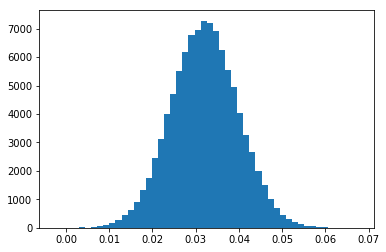

In [19]:
# plot distribution of difference of proportion
import matplotlib.pyplot as plt
%matplotlib inline
_, ax = plt.subplots()
_ = ax.hist(mean_bs_replicates_diff, bins = 50)

In [20]:
# standard error of the proportion difference
str_error = np.std(mean_bs_replicates_diff)
# margin of error
1.96 * str_error

0.015206373586628715

In [21]:
# confidence interval
np.percentile(mean_bs_replicates_diff, [2.5, 97.5])

array([ 0.01685328,  0.0472039 ])

<div class="span5 alert alert-success">
<h2>SOLUTION: What test is appropriate for this problem?</h2>

<p>This is an interesting question, and it can be argued that there are two possible correct answers (such is life). First note the wording of the question: does race have a *significant impact* on callback. This usually suggests a $\chi^2$-test, but the $\chi^2$-test requires *frequencies* rather than percentages. Interestingly, one of the code snippets above uses frequency so we will look at that in a bit.</p>

For now, a two-sample $z$-test:

$$z = \frac{\left( \hat{p}_W - \hat{p}_B \right) - 0}{\sqrt{\hat{p} (1 - \hat{p)} \left( \frac{1}{n_W} + \frac{1}{n_B}\right)}}$$

where

$$\hat{p} = \frac{y_W + y_B}{n_W + n_B}$$

The null and alternate hypotheses:

$$H_0: p_B = p_W$$
$$H_A: p_B \ne p_W$$

CLT applies because we assume that the samples are representative of the population. The observations in each sample are assumed to be independent since the sample was drawn randomly.

In [23]:
w = data[data.race=='w']
b = data[data.race=='b']

n_w = len(w)
n_b = len(b)

prop_w = np.sum(w.call) / len(w)
prop_b = np.sum(b.call) / len(b)

prop_diff = prop_w - prop_b
phat = (np.sum(w.call) + np.sum(b.call)) / (len(w) + len(b))

z = prop_diff / np.sqrt(phat * (1 - phat) * ((1 / n_w) + (1 / n_b)))
pval = stats.norm.cdf(-z) * 2
print("Z score: {}".format(z))
print("P-value: {}".format(pval))

Z score: 4.108412152434346
P-value: 3.983886837585077e-05


In [24]:
moe = 1.96 * np.sqrt(phat * (1 - phat) * ((1 / n_w) + (1 / n_b)))
ci = prop_diff + np.array([-1, 1]) * moe
print("Margin of Error: {}".format(moe))
print("Confidence interval: {}".format(ci))

Margin of Error: 0.015281912310894095
Confidence interval: [ 0.01675094  0.04731477]


<div class="span5 alert alert-success">
<p>The p-value is practically 0 so we reject the null hypothesis that white and black sounding names have the same callback rate. They do not.</p>

<p>Since 0 is not in the confidence interval, we reject the null hypothesis with the same conclusion.</p>

<h4>SOLUTION: Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?</h4>

<p>No! While our test did show that there is a difference in callback rate based on race alone, there are other variables that may also contribute to, or interact with, race to explain the difference. In the original research paper, the researchers cited geography/city as a confounding variable. Additionally, we could also look at education and experience levels as well. But, in our very narrow example, we have shown that there is a significant difference in callback rates between white people and black people.</p>

<p>The $\chi^2$ approach:</p>
</div>

In [25]:
cont_table = pd.crosstab(index=data.call, columns=data.race)
chi2, pval, _, _ = stats.chi2_contingency(cont_table)
print("Chi-squared test statistic: {}".format(chi2))
print("p-value: {}".format(pval))

Chi-squared test statistic: 16.44902858418937
p-value: 4.997578389963255e-05


<div class="span5 alert alert-success">
The chi-squared test yields a similar result. We reject the null hypothesis that race and callback rate are independent. The margin of error and confidence interval calculations are a bit more complicated because the chi-squared distribution is not always symmetric, depending on the number of degrees of freedom.
</div>